In [ ]:
! pip uninstall -y kaggle
! pip install --upgrade pip
! pip install kaggle==1.5.12

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zzisaac","key":"faa744fddbe350cee2e11ead9cea999b"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading kaggle dataset to the working directory of Colab instance
! kaggle datasets download jonathanbesomi/rsna-miccai-png
! unzip /content/rsna-miccai-png.zip


In [ ]:
# Downloading BraTs2020.h5 (weights of an image segmentation UNet trained on the BraTs2020 dataset)
! kaggle kernels output arashmehrzadi/brain-tumor-segmentation-unet -p /content/

In [ ]:
'''
This project was in response to the RSNA-MICCAI Brain Tumour Radiogenomic Classification competition on Kaggle.
(https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification)

There are 2 parts to this model: 
1. Pretrained UNet for image segmentation (code is taken from https://www.kaggle.com/frlemarchand/brain-tumour-segmentation-in-mri-slices/notebook)
2. CNN with input as best image of each study and output as 0 or 1 (self-written code)
'''

## BUILD UNET MODEL
#input image
img_width = img_height = 512
img_channels = 1

import numpy as np
import math
import random
import os
from PIL import Image
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from keras import backend as K
from sklearn.model_selection import train_test_split

def Convolution(input_tensor,filters):
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    return x

def model(input_shape):
    
    inputs = Input((input_shape))

    #Maxpooling
    conv_1 = Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_1)
    
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_2)
    
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_3)
    
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (conv_4)

    #Upsampling
    conv_5 = Convolution(maxp_4,512)
    upsample_6 = UpSampling2D((2, 2)) (conv_5)
    
    conv_6 = Convolution(upsample_6,256)
    upsample_7 = UpSampling2D((2, 2)) (conv_6)
    
    upsample_7 = concatenate([upsample_7, conv_3])
    
    conv_7 = Convolution(upsample_7,128)
    upsample_8 = UpSampling2D((2, 2)) (conv_7)
    
    conv_8 = Convolution(upsample_8,64)
    upsample_9 = UpSampling2D((2, 2)) (conv_8)
    
    upsample_9 = concatenate([upsample_9, conv_1])
    
    conv_9 = Convolution(upsample_9,32)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_9)
    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model


In [ ]:
#Using the pre-trained weights BraTs2020.h5
input_size = 240
model = model(input_shape = (input_size, input_size, 1))
model.load_weights("/content/BraTs2020.h5")
model.summary()

In [ ]:
path_to_training_studies = "/content/train"
training_studies = os.listdir(path_to_training_studies)
random.seed(24)
studies_to_view = random.choices(training_studies, k=3) #3 random studies

In [ ]:
def prediction(img_path, save_folder=""):
    '''
    resize the input image and run the prediction
    while removing some noise and saving the mask if required
    '''
    
    test_img = Image.open(img_path)
    resized_img = np.array(test_img.resize((input_size, input_size)))
    
    result = model.predict(np.array([resized_img]))[0].transpose(2,0,1)[0]

    #Remove some of the noise in the predicted mask
    kernel = np.ones((10,10),np.uint8)
    result = cv.morphologyEx(result, cv.MORPH_OPEN, kernel)
    result = np.where(result > 0.9, 1, 0)

    #Renaming and saving resized result to save_folder
    if save_folder!="":
        save_path = img_path.replace("content", save_folder)
        save_path = save_path.replace(".png","-tumour-mask.png").replace("/T1w","")
        save_folder = save_path.replace(save_path.split("/")[-1],"")
        if not os.path.exists(save_folder):
            os.mkdir(save_folder)
        
        resized_result = cv.resize(result.astype("float32"), (512,512), interpolation = cv.INTER_AREA)
        cv.imwrite(save_path, resized_result)    
    
    return resized_img, result

def find_tumour(study_filename, save_folder="", dataset=path_to_training_studies):
    '''
    Apply the model on all MRI slices of study and return the 
    slice with the greatest amount of pixels with tumour
    '''
    
    max_detected = 0
    tumour_slice = ""
    MRI_slices = os.listdir(os.path.join(dataset, study_filename, "T1w"))
    
    for MRI_slice_filename in MRI_slices:
        path_to_slice = os.path.join(dataset, study_filename, "T1w", MRI_slice_filename)
        formatted_img, result = prediction(path_to_slice, save_folder)
        
        tumour_pixel = len(result[result>0.5])
        
        if max_detected <= tumour_pixel:
            max_detected = tumour_pixel
            tumour_slice = path_to_slice
    return tumour_slice

def display(img, result):
    plt.imshow(np.squeeze(img),cmap='gray')
    plt.imshow(np.squeeze(result),alpha=0.6,cmap='Reds')
    plt.show()

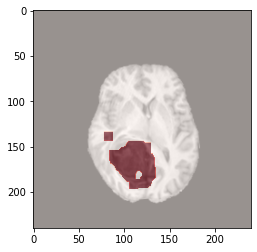

In [ ]:
MRI_slice_filename = find_tumour(studies_to_view[0])
img, result = prediction(MRI_slice_filename)
display(img, result)

In [ ]:
os.mkdir('/content/working')
os.mkdir('/content/working/rsna-miccai-tumour-mask')
os.mkdir('/content/working/rsna-miccai-tumour-mask/train')
os.mkdir('/content/working/rsna-miccai-tumour-mask/test')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/gdrive/MyDrive/best-img/train/.' '/content/working/rsna-miccai-tumour-mask/train'
!cp -r '/content/gdrive/MyDrive/best-img/val/.' '/content/working/rsna-miccai-tumour-mask/train'

/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
#Check that all files are copied
print(len(os.listdir('/content/gdrive/MyDrive/best-img/val')))
print(len(os.listdir('/content/gdrive/MyDrive/best-img/train')))
print(len(os.listdir('/content/working/rsna-miccai-tumour-mask/train')))

117
467
584


In [ ]:
#Generate best img for each training study
train_folder_content = os.listdir(path_to_training_studies)
for study_folder in train_folder_content:
    MRI_slice_filename = find_tumour(study_folder, save_folder="", dataset=path_to_training_studies)
    prediction(MRI_slice_filename, save_folder="content/working/rsna-miccai-tumour-mask")

#Generate best img for each test study
'''path_to_test_studies = "/content/test"
test_folder_content = os.listdir(path_to_test_studies)
for study_folder in test_folder_content:
    MRI_slice_filename = find_tumour(study_folder, save_folder="", dataset=path_to_test_studies)
    prediction(MRI_slice_filename, save_folder="content/working/rsna-miccai-tumour-mask")'''

In [ ]:
#Build simple CNN model

def model(input_shape):
    
    inputs = Input((input_shape))

    #Maxpooling
    c1 = Conv2D(16, (3,3), activation='relu') (inputs)
    mp1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (c1)
    
    c2 = Conv2D(32, (3,3), activation='relu') (mp1)
    mp2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (c2)
    
    c3 = Conv2D(64, (3,3), activation='relu') (mp2)
    mp3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (c3)
    
    c4 = Conv2D(64, (3,3), activation='relu') (mp3)
    mp4 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (c4)

    c5 = Conv2D(64, (3,3), activation='relu') (mp4)
    mp5 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same') (c5)

    # Flatten
    f1 = tf.keras.layers.Flatten() (mp5)

    # 512 neuron hidden layer
    d1 = tf.keras.layers.Dense(512, activation='relu') (f1)

    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class and 1 for the other
    outputs = tf.keras.layers.Dense(1, activation='sigmoid') (d1)

    
    model = Model(inputs=[inputs], outputs=[outputs]) 
    
    return model

input_size = 512
model = model(input_shape = (input_size, input_size, 1))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 510, 510, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 64)        0   

In [ ]:
#upload train_labels.csv
files.upload()

labels = np.genfromtxt('train_labels.csv', delimiter=',')
labels = np.concatenate((labels[1:191,1],labels[192:,1]),axis=None) #Remove study 00123


Saving train_labels.csv to train_labels (2).csv


In [ ]:
path_to_best_img = '/content/working/rsna-miccai-tumour-mask/train'
list_of_studies = os.listdir(path_to_best_img)
k = len(list_of_studies)
x = np.zeros((k,512,512))
for i in range(k):
    study = list_of_studies[i]
    best_img = os.listdir(os.path.join(path_to_best_img, study))
    im = Image.open(os.path.join(path_to_best_img, study, best_img[0]))
    x[i] = np.asarray(im)

In [ ]:
import random
#80% used for training
z = random.sample(range(584),468)
#20% used for validation
z2 = [item for item in range(584) if item not in z]

In [ ]:
y_train = labels[z]
y_val = labels[z2]

x_train = x[z,:,:]
x_val = x[z2,:,:]

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(x_train.shape)
print(x_val.shape)

(468,)
(116,)
(468, 512, 512)
(116, 512, 512)


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=16,
                    epochs=100)

Epoch 1/100
30/30 [==============================] - 5s 128ms/step - loss: 0.4577 - accuracy: 0.9231
Epoch 2/100
30/30 [==============================] - 4s 125ms/step - loss: 0.1140 - accuracy: 0.9701
Epoch 3/100
30/30 [==============================] - 4s 124ms/step - loss: 0.0472 - accuracy: 0.9765
Epoch 4/100
30/30 [==============================] - 4s 126ms/step - loss: 0.0206 - accuracy: 0.9893
Epoch 5/100
30/30 [==============================] - 4s 126ms/step - loss: 0.0167 - accuracy: 0.9893
Epoch 6/100
30/30 [==============================] - 4s 125ms/step - loss: 0.0158 - accuracy: 0.9893
Epoch 7/100
30/30 [==============================] - 4s 126ms/step - loss: 0.0155 - accuracy: 0.9893
Epoch 8/100
30/30 [==============================] - 4s 126ms/step - loss: 0.0153 - accuracy: 0.9893
Epoch 9/100
30/30 [==============================] - 4s 125ms/step - loss: 0.0152 - accuracy: 0.9893
Epoch 10/100
30/30 [==============================] - 4s 124ms/step - loss: 0.0151 - accura

In [ ]:
#calculate accuracy of model
val_pred = model.predict(x_val)
accuracy = np.mean(y_val == (val_pred>0.5))
print(accuracy)

0.5124851367419738
